# T017 · Advanced NGLview usage

Authors:

- Jaime Rodríguez-Guerra, 2021, Volkamer Lab, Charité Universitätsmedizin
- Dominique Sydow, 2021, Volkamer Lab, Charité Universitätsmedizin

## Aim of this talktorial

[NGLView](http://nglviewer.org/nglview/latest/) is a powerful Jupyter widget that allows you to show molecular structures in your notebooks in a 3D interactive view! It supports both single conformations and trajectories, as well as a plethora of representations. In this talktorial we will cover how to use it in different scenarios, from simpler cases to more intricate ones.

### Contents in *Theory*

* NGL and NGLView
* Jupyter Widgets
* JavaScript, TypeScript and WebGL

### Contents in *Practical*

* Make sure NGLView works
    * Experiment with the interactive controls
* Basic API usage:
    * Show a structure using its PDB identifier
    * Show a structure using a local file
    * Customize the representations
    * Load more than one structure
    * Show and hide components
    * Saving the widget state as a screenshot for offline viewing
* Advanced usage:
    * Create interactive widget components
    * Access the JavaScript layer
    * Example one: custom tooltips
    * Example two: distance calculations
* Debugging tips:
    * Fixing installation


### References

* **NGL manuscript**: <i>Nucl Acids Res.</i> (2015), <b>43</b> (W1), W576-W579 (https://academic.oup.com/nar/article/43/W1/W576/2467902)
* [NGL documentation](http://nglviewer.org/ngl/api/) and [repository](https://github.com/nglviewer/ngl)
* **NGLView manuscript**: <i>Bioinformatics</i> (2018), <b>34</b> (7), 1241-1242 (https://academic.oup.com/bioinformatics/article/34/7/1241/4721781)
* [NGLView documentation](http://nglviewer.org/nglview/latest/) and [repository](https://github.com/nglviewer/nglview)
* [NGLView Q&A issues](https://github.com/nglviewer/nglview/issues?q=is%3Aissue+label%3AQ%26A)
* [NGLView examples](https://github.com/nglviewer/nglview/tree/master/examples)
* [Jupyter Widgets (IPyWidgets)](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html)

## Theory

### NGL and NGLView

_TODO_

* What NGL does
* What NGLView does

### Jupyter Widgets: Python and JavaScript

_TODO_

* How this project marries Python and JavaScript together through the Notebook and Lab browser interfaces.

## Practical

> Note: Since NGLView is an interactive widget, most of the features discussed in this talktorial will be best enjoyed in a running Jupyter environment. If you are reading this from the online static preview, you are missing out a lot of cool things!

In [2]:
from pathlib import Path

HERE = Path(_dh[-1])
DATA = HERE / "data"

### First steps: make sure everything works!

In [3]:
import nglview as nv
nv.demo()

NGLWidget()

If you don't see a 3D interactive view of protein in the output of the cell below, check the **Troubleshooting tips** section at the end of this notebook.

#### Experiment with the interactive controls

The view above is interactive! You can use your mouse to:

* **Translation**: right click + drag
* **Rotation**: left click + drag
* **Z-axis rotation**: <kbd>Ctrl</kbd> + right click + drag
* **Zoom**: scroll wheel
* **Center view**: left click on the desired atom (or its representation)

You can also represent distances, angles and dihedrals by following this procedure:

1. Right click on a single atom. You'll see a green sphere wrapping it.
2. Right click on another atom. You'll see now two green spheres. You can add up to four atoms to a selection this way (including the first one)
3. Right click again on the last atom you selected to finalize the operation. 
    * If you picked two atoms, you'll see a dashed line between the two atoms, along with the reported **distance** in Å.
    * If you picked three atoms, you'll see a circular sector with the **angle** reported in degrees (°).
    * If you picked four atoms, you'll see a circular sector with the **dihedral angle** reported in degrees (°).

To remove a distance/angle/dihedral representation, repeat the sequence on the same atoms.

![Geometric measurements on NGLView](images/nglview_picking.gif)

Figure: Step by step procedure to represent geometric measurements in NGLView.

### Basic API usage

`nglview` wraps the `ngl.js` JavaScript library with an `IPyWidget` subclass named `NGLWidget`. You can create widget objects using the class directly:

```python
viewer = nv.NGLWidget()
```

But for simple cases, it's more convenient to use the `nv.show_*` helper functions. This is the current list of functions available:

In [6]:
print("NGLView version:", nv.__version__)
for attr in dir(nv):
    if attr.startswith("show_"):
        print(f"  nv.{attr}(...)")

NGLView version: 2.7.7
  nv.show_ase(...)
  nv.show_asetraj(...)
  nv.show_biopython(...)
  nv.show_file(...)
  nv.show_htmd(...)
  nv.show_iodata(...)
  nv.show_iotbx(...)
  nv.show_mdanalysis(...)
  nv.show_mdtraj(...)
  nv.show_openbabel(...)
  nv.show_parmed(...)
  nv.show_pdbid(...)
  nv.show_prody(...)
  nv.show_psi4(...)
  nv.show_pymatgen(...)
  nv.show_pytraj(...)
  nv.show_qcelemental(...)
  nv.show_rdkit(...)
  nv.show_rosetta(...)
  nv.show_schrodinger(...)
  nv.show_simpletraj(...)
  nv.show_structure_file(...)
  nv.show_text(...)
  nv.show_url(...)


#### Show a structure using its PDB identifier

Use `nv.show_pdbid`:

In [7]:
nv.show_pdbid("3pk2")

NGLWidget()

#### Show a structure using a local file

In other cases, you will have a local file produced by other parts of your pipeline, or downloaded from a non-RCSB resource. To load local files, you would need to use `nv.show_file("path/to/local/file.pdb")`. If you are using Jupyter Notebook as the UI, this will work out of the box.

However, the Jupyter ecosystem is moving towards Lab, where things work a bit differently. One of them is accessing local files. This is a known issue (<link to NGLVIEW issue>), so we are going to provide a workaround until this is fixed. The trick consists of opening the file with Python first, and then passing the handler to NGLView, instead of the path. You also need to specify the extension for that file handler (`pdb` in this example). `display(...)` is needed to explicitly export the widget view to the output because we are inside the `open()` context manager.

In [59]:
with open(DATA / "1ARM.pdb") as f:
    display(nv.show_file(f, ext="pdb"))

NGLWidget()

You can also save the widget returned by the function (`view`, by convention) and evaluate it at the global level:

In [53]:
with open(DATA / "1ARM.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view

NGLWidget()

This has the advantage of allowing you to modify the state of the widget from the Python interface, as you will see in the next steps:

#### Saving the widget state as a screenshot for offline viewing

In some cases, you might want to take a screenshot of the current state of the widget (e.g. to save a static preview). This is a step that involves three separate cells _necessarily_. Although it is very tempting to merge all the cells together, it will _not_ work unless each cell is run separately:

* Show the widget output. You can use your mouse to move it to a nice orientation, if you want.
* Export the canvas contents from the JavaScript layer to the Python layer
* Export the contents of the Python layer to the cell output

In [54]:
view

NGLWidget(n_components=1)

In [55]:
view.render_image(trim=True, factor=2);  # trim=True will remove the empty padding in the canvas

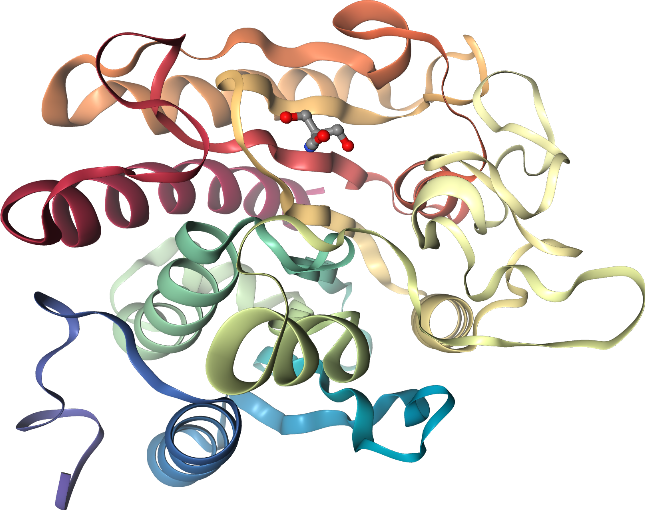

In [56]:
view._display_image()

#### Customize the representations

#### Control representations by selections

If you combine all those `add_*` functions with [NGL's powerful selection language](http://nglviewer.org/ngl/api/manual/selection-language.html) you can adapt the style of your structures to your liking. This is specially useful when you disable the default representation to start from scratch:

In [60]:
view = nv.show_pdbid("3pk2", default_representation=False)
view

NGLWidget()

The above widget is now completely _blank_. That doesn't mean the structures were not loaded. We have to add representations. Look how the widget updates over the next steps:

In [38]:
# add ribbon to protein only
view.add_cartoon("protein")
view.render_image(trim=True, factor=2);

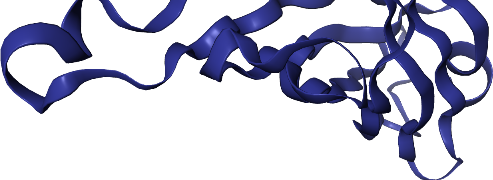

In [39]:
view._display_image()

In [40]:
# by default, the camera is not centered
view.center()
view.render_image(trim=True, factor=2);

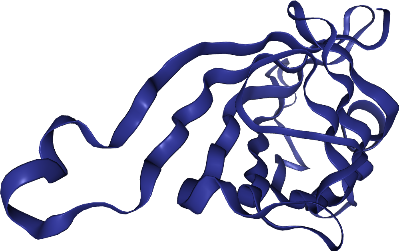

In [41]:
view._display_image()

In [42]:
# add ball & stick for the ligand(s)
view.add_ball_and_stick("ligand")
view.render_image(trim=True, factor=2);

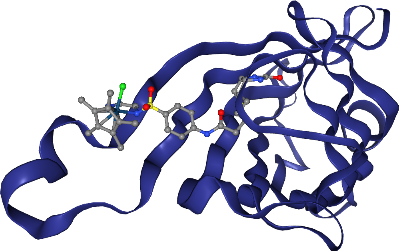

In [43]:
view._display_image()

In [44]:
# crystallographic waters should be displayed, but in a subtle way that does not get in the way
view.add_line("water")
view.render_image(trim=True, factor=2);

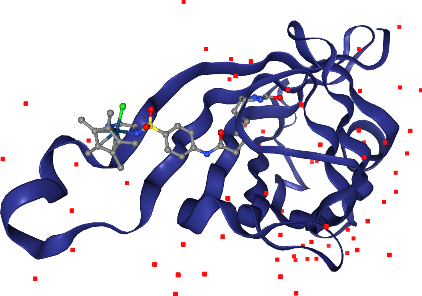

In [45]:
view._display_image()

In [46]:
# represent the Iridium ion with a larger radius
view.add_spacefill("_Ir")
view.render_image(trim=True, factor=2);

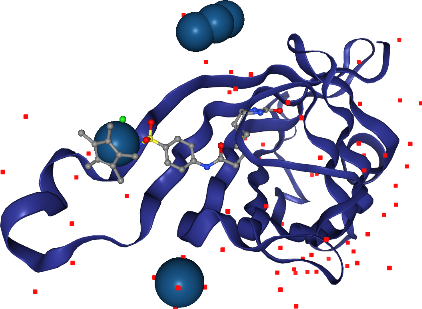

In [47]:
view._display_image()

In [48]:
# oh, there are more than one, let's undo that
view.remove_spacefill()
view.render_image(trim=True, factor=2);

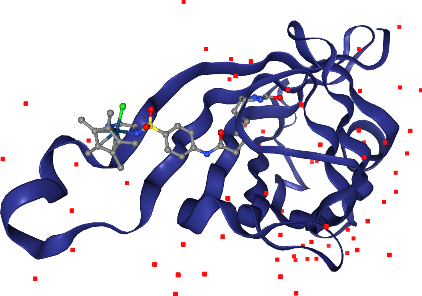

In [49]:
view._display_image()

In [50]:
# This is how you say "the iridium atom that is part of the ligand"
view.add_spacefill("ligand and _Ir")
view.render_image(trim=True, factor=2);

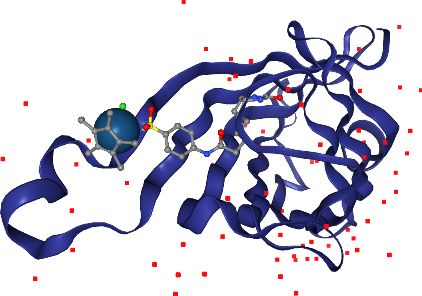

In [51]:
view._display_image()

You can add more representations using the `view.add_*` shorthands. The following ones are available. Take into account that in NGL, a representation can include visual tools other than how a protein or ligand is depicted. For example, calculating (and showing) distance measurements is also a _representation_. For more details, check this part of the [NGL documentation](http://nglviewer.org/ngl/api/manual/molecular-representations.html).

In [12]:
for attr in dir(view):
    if attr.startswith("add_"):
        print(f"view.{attr}(...)")

view.add_axes(...)
view.add_backbone(...)
view.add_ball_and_stick(...)
view.add_cartoon(...)
view.add_class(...)
view.add_component(...)
view.add_contact(...)
view.add_distance(...)
view.add_helixorient(...)
view.add_hyperball(...)
view.add_label(...)
view.add_licorice(...)
view.add_line(...)
view.add_pdbid(...)
view.add_point(...)
view.add_principal_axes(...)
view.add_representation(...)
view.add_ribbon(...)
view.add_rocket(...)
view.add_rope(...)
view.add_simplified_base(...)
view.add_slice(...)
view.add_spacefill(...)
view.add_structure(...)
view.add_surface(...)
view.add_trace(...)
view.add_traits(...)
view.add_trajectory(...)
view.add_tube(...)
view.add_unitcell(...)


Note that each representation type admits arbitrary keyword arguments that are not documented in the Python layer. Refer to the JavaScript documentation to see how you can customize each one. See the `*Representation*` objects [here](http://nglviewer.org/ngl/api/typedef/index.html).

#### NMR and multimodel structures 
If you are dealing with NMR structures or multimodel PDBs, there will be multiple conformations. By default, only the first one will be loaded:

In [57]:
# By default, first model only
nv.show_pdbid("1rfo")

NGLWidget()

To display all of them, you need to disable the default representation and provide your own:

In [58]:
# all models require custom representation
view = nv.show_pdbid("1rfo", default_representation=False)
view.center()
view.add_cartoon()
view

NGLWidget()

#### Load more than one structure

Once you have the `view` instance around, you can start doing more advanced stuff with NGLView! For example, loading more than one structure! 

Let's start with some depictions of _Bos taurus_' carboxypeptidase. The RCSB contains several structures for this enzyme:

* `1YME`: STRUCTURE OF CARBOXYPEPTIDASE
* `1ARL`: CARBOXYPEPTIDASE A WITH ZN REMOVED
* `1ARM`: CARBOXYPEPTIDASE A WITH ZN REPLACED BY HG


In [61]:
view = nv.show_pdbid("1YME")
view

NGLWidget()

Now, let's add `1ARM`, which contains an additional ligand `TRS`. Note that the view _above_ will get updated automatically:

In [62]:
view.add_component(nv.PdbIdStructure("1ARM"))

`view` contains now _two_ components, as shown in:

In [63]:
view.n_components

2

The individual components are available via `view.component_{index}` or `view[{index}]`:

In [64]:
view[0]

In [65]:
view.component_0

#### Show and hide components


Since each component can control their own representations, we can hide some parts on command using the `.hide()`. This action is undone with `.show()`.

In [34]:
view[1].hide()

Note how the TRS ligand disappeared from the view above. Now, let's show it again:

In [35]:
view[1].show()

You can show the same view again if you want! No need to stick to the output some cells above. The contents of both will get updated and synced as needed.

In [31]:
view

NGLWidget(n_components=2)

Another alternative is to create a new _output view_ if you are using Jupyter Lab. To do that, right-click in the left margin of the input cell above (the one with `view`) and select:

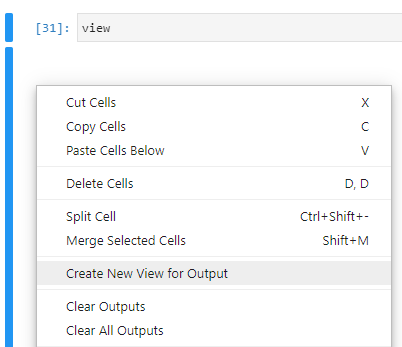

### Advanced usage



#### Create interactive interfaces

One of the secret features of NGLView is the interactive GUI! Enabling it is surprisingly easy and will give you some extra control on the representations.

There are two GUIs included:

* The default (`gui=True`), which uses IpyWidgets
* The one NGL uses in their [demo app](http://nglviewer.org/ngl/)

In [69]:
# This is the default one

nv.show_pdbid("1RFO", gui=True)

NGLWidget()

Now bring in the NGL GUI. Sometimes the canvas does not load, so try to execute it twice. See discussion [here](https://github.com/nglviewer/nglview/issues/901#issuecomment-747163835) for more details

In [71]:
view = nv.show_pdbid("1RFO")
view.gui_style = "NGL"
view

NGLWidget(gui_style='ngl')

##### Customize your own GUI with IPyWidgets

Since `nglview` exposes NGL as an IPython/Jupyter widget, that means it can be used to compose advanced dashboards in combination with the [IPyWidgets project](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html).

For example, a simple model picker for multimodel structures like in NMR studies:

In [73]:
view = nv.show_pdbid("1RFO", default_representation=False)
view.add_ribbon("protein")
view.center()
view

NGLWidget()

This is what we need to display a single model: clear all representations and add the ribbon only on model N with the syntax `/N`:

In [88]:
view.clear()
view.add_ribbon("/0")

We can put this in a function:

In [84]:
def show_one_model_only(view, model_id):
    view.clear()
    view.add_ribbon(f"/{model_id}")

Look how it reacts to your function calls:

In [89]:
show_one_model_only(view, 1)

What if we let an IPyWidget do that for us? That's how `interact` works! Read the [documentation](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html#Using-Interact) for more details, but the gist is:

* `interact` takes a function that accepts some parameters
* Those parameters can be sent via changes in a widget (`model_id`), or manually defined as non-dynamic with `fixed(parameter)`.
* `interact` does some magic to infer which kind of widget is best for each parameter. If you pass a tuple of `int` (start, end), it will create a discrete slider, for example.
* Changing the state of the widget will result in calling that function with the new parameters. Since we are reacting on `view`, you will see the changes in real time!

In [98]:
from ipywidgets import interact, fixed

interact(show_one_model_only, view=fixed(view), model_id=(0, 9))
view

interactive(children=(IntSlider(value=4, description='model_id', max=9), Output()), _dom_classes=('widget-inte…

NGLWidget(n_components=1)

#### Access the JavaScript layer

NGL is an incredibly powerful JavaScript library. NGLView exports the most useful bits to Python, which allows us to control certain things in a very convenient way. However, sometimes we need to leverage both layers (JS and Python) to achieve some advanced representations. To do so, we can use some private methods in `nglview.NGLWidget`. Namely:

* `nglview.NGLWidget._remote_call`: Run a method on a NGL JS object, with positional arguments `args` and keyword arguments `kwargs`. You have to choose the target object first:
    * `target="Widget"`: The IPyWidget wrapper for the NGL Stage. [Check public methods](https://github.com/nglviewer/nglview/blob/2cd42979e0c39c163b6728f59ffea6e9d8cd56db/js/src/widget_ngl.ts#L73).
    * `target="Stage"`: Run any method on `Stage`. [List of methods](http://nglviewer.org/ngl/api/class/src/stage/stage.js~Stage.html#methodSummary). Most of the time you will use this one.
    * `target="Viewer"`: Run any method on `Viewer`. [Check public methods](https://github.com/nglviewer/ngl/blob/master/src/viewer/viewer.ts#L173).
    * `target="compList"`: Run any method on `compList`, the list of loaded components in the stage. Maybe useful to query the JS list for a specific component.
    * `target="StructureComponent"`: Run any method on `StructureComponent`; each individual component. [List of methods](http://nglviewer.org/ngl/api/class/src/component/structure-component.js~StructureComponent.html).
* `nglview.NGLWidget._execute_js_code`: This will allow you to execute arbitrary JavaScript code. In that code, the JS counterpart of the IpyWidget can be referred by `this`. The NGL `Stage` instance is available at `this.stage`. It can be more powerful than `_remote_call` for complex cases!

Let's try some simple examples first.

In [174]:
view = nv.show_pdbid("2G1T")  # Human ABL1 kinase
view

NGLWidget()

Let's add some random text. This is possible via the `addShape` widget method- Some considerations:

* `Widget.addShape` requires args with a shape identifier or name (any `str`) and a list of sublists, where each sublist contains the kind of "shape" and its arguments. [See the function here](https://github.com/nglviewer/nglview/blob/2cd42979e0c39c163b6728f59ffea6e9d8cd56db/js/src/widget_ngl.ts#L759).
* The arguments for each type shape can be checked on NGL documentation; e.g. for [text](http://nglviewer.org/ngl/api/class/src/buffer/text-buffer.js~TextBuffer.html). Use the search bar to find the corresponding `*Buffer`.
* The arguments are passed _without_ keywords, just the values, positionally.

Let's add some red (encoded as RGB `[1, 0, 0]`) text (`TeachOpenCADD`) at the XYZ coordinates `[60, 0, -20]`.

In [175]:
view._remote_call("addShape", target="Widget", 
    args=("redText",  [["text", [60, 0, -20], [1, 0, 0], 10, "TeachOpenCADD"]])
)

Note that this can be achieved in a similar way using `_execute_js_code`. The difference is how to pass arguments, which would need to be substituted in a f-string. Hopefully, for some simple cases, JS and Python share a similar syntax (e.g. lists and strings). Let's add some more text, but now it will be blue and in a different position:

In [184]:
view._execute_js_code("""
this.addShape("blueText", [["text", [60, 20, -20], [0, 0, 1], 10, "TeachOpenCADD"]])
""")

This might be cumbersome in some cases, but in others we don't have a choice. For example, if we want to remove one of the shapes, we can only do it via `_execute_js_code`:

In [185]:
view._execute_js_code("""
this.stage.removeComponent(this.stage.getComponentsByName("blueText").first)
""")

##### Debugging JavaScript code

You might be wondering, how can I find the right JS command if autocomplete does not work and the documentation is tricky to follow? Your best chance is using the Developer Tools in your browser!

The trick is to export the NGL Widget, represented by `this` under the `_execute_js_code` context, to your browser tab context. To do so, execute this snippet:

In [208]:
view._execute_js_code("document.nglview = this;")

If you open your Developer Tools console (<kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>J</kbd> in Chrome, <kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>K</kbd> in Firefox), you can inspect the `document.nglview` object:

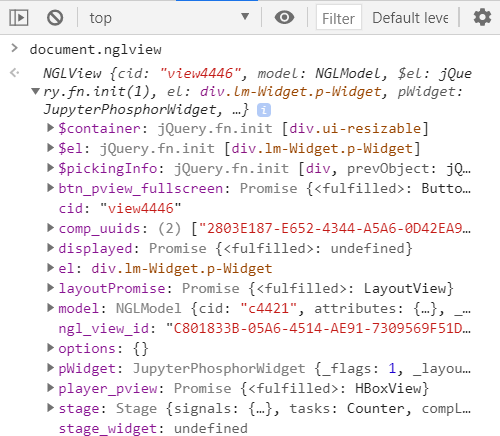

For your convenience, you can alias it to something quicker to type:

```javascript
nv = document.nglview;
```

and inspect `nv` instead. Autocomplete with <kbd>Tab</kbd> should work as expected!

Tips and pitfalls:

* Most of the interesting stuff will be under `nv.stage`, like `nv.stage.compList`.
* The snippet you end up developing in the console will work as a `_execute_js_code` snippet as long as you replace back `document.nglview` (or your alias `nv`) with `this`.
* If you reload the NGL Widget from the notebook (e.g. by calling `nv.show_pdbid(...)` again), you need to re-run `view._execute_js_code("document.nglview = this;")`
* The console allows for non-`;` terminated lines, but make sure to end each line with `;` in the snippet.
* Javascript comments start with `//` not `#`

##### Practical example: show residues around ligand

This is a popular operation we often perform while studying protein-ligand complexes, but NGLView does not expose that directly. NGL does offer that functionality, so we can still query JS for this!

Let's open a kinase with a inhibitor, like EGFR. The PDB [structure](https://klifs.net/details.php?structure_id=783) `2ITO` seems to be bound by gefitinib with residue code `IRE`.

In [218]:
view = nv.show_pdbid("2ITO")
view.center("IRE")
view

NGLWidget()

In [219]:
view._execute_js_code("""
// Get first (and only) loaded component: our protein-ligand system
var system = this.stage.compList[0]; 
// Store current selection, we will need it laer
var prevSele = system.selection.string;
// Set selection to our desired ligand
system.setSelection("IRE");
// Select all atoms within 5A from the ligand
var around = system.structure.getAtomSetWithinSelection(system.selection, 5.0);
// Extend selection so it includes full residues
var around_complete = system.structure.getAtomSetWithinGroup(around);
// Add representation for those atoms
system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
// Restore selection to original one; otherwise changes won't be reflected
system.setSelection(prevSele)
""")

To parameterize this block of JS code you can use f-strings in a function! However, make sure to either:

* Escape already present curly braces `{ }` by doubling them:

```diff
- system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
+ system.addRepresentation("licorice", {{sele: around_complete.toSeleString()}});
```

* Split `{}`-containing substrings from the f-string parts, thanks to implicit string concatenation:

```python
js = (
f"""
// Get first (and only) loaded component: our protein-ligand system
var system = this.stage.compList[{index}]; 
// Store current selection, we will need it laer
var prevSele = system.selection.string;
// Set selection to our desired ligand
system.setSelection("{ligand}");
// Select all atoms within 5A from the ligand
var around = system.structure.getAtomSetWithinSelection(system.selection, {radius});
"""
# these extra quotes create two different strings: f-string above, regular string below
"""
// Extend selection so it includes full residues
var around_complete = system.structure.getAtomSetWithinGroup(around);
// Add representation for those atoms
system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
// Restore selection to original one; otherwise changes won't be reflected
system.setSelection(prevSele)
"""
# In the end they are joined anyway, but _after_ the formatting has taken place :)
)
```

Knowing this, you can define `show_residues_around` like this:

In [220]:
def show_residues_around(view, component_index=0, selection="ligand", radius=5.0):
    js = (
        f"""
        // Get first (and only) loaded component: our protein-ligand system
        var system = this.stage.compList[{component_index}]; 
        // Store current selection, we will need it laer
        var prevSele = system.selection.string;
        // Set selection to our desired ligand
        system.setSelection("{selection}");
        // Select all atoms within 5A from the ligand
        var around = system.structure.getAtomSetWithinSelection(system.selection, {radius});
        """
        """
        // Extend selection so it includes full residues
        var around_complete = system.structure.getAtomSetWithinGroup(around);
        // Add representation for those atoms
        system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
        // Restore selection to original one; otherwise changes won't be reflected
        system.setSelection(prevSele)
        """
    )
    view._execute_js_code(js)

Let's see if it works!

In [222]:
view = nv.show_pdbid("1KSW")
show_residues_around(view)
view.center("ligand")
view

NGLWidget()

### Troubleshooting tips

The Jupyter ecosystem is vast and changes rapidly, keeping up-to-date with the latest additions is tricky and resource consuming, so ending up with a broken NGLView installation is not uncommon. The following packages might affect the functionality of NGLView. If one of them had a recent version change (specially major versions, like Jupyter Lab 2 -> Jupyter Lab 3), that might one of the explanations:

* `jupyter`
* `jupyterlab`
* `notebook`
* `ipywidgets`
* `nglview` itself


#### Check which Jupyter platform you are working from

While the community transitions from Jupyter Notebook to Jupyter Lab, these alternative frontends for our beloved notebooks will coexist for a while, making everything a bit more confusing. Which one are you using? Check the table below.

| Application      | Package name         | Shell command      | URL style                 | Features                                                                                                                                                  |
|------------------|----------------------|--------------------|---------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Jupyter Notebook | `notebook`           | `jupyter notebook` | `127.0.0.1:8888/tree`     | One notebook per tab; Less resource intensive; Legacy project                                                                                             |
| Jupyter Lab v2   | `jupyterlab`         | `jupyter lab`      | `127.0.0.1:8888/lab`      | Multiple notebooks per tab; You can compose complex interfaces; Consumes more resources; Extensions must be built on the machine before installation      |
| Jupyter Lab v3   | `jupyterlab`         | `jupyter lab`      | `127.0.0.1:8888/lab`      | No need to build extensions                                                                                                                               |
| Jupyter Classic  | `jupyterlab-classic` | `jupyter classic`  | `127.0.0.1:8888/classic`  | Same UI style as `notebook`, but using the modern framework behind `lab`                                                                                  |


As a result, installing `nglview` on your machine involves different step depending on which Jupyter UI you are going to use.

#### How to install `nglview`, the right way

If you didn't know about the subtle differences  explained above, there's a chance you have several instances of `nglview` installed in your computer. Having both `conda` and `pip` available makes it more difficult, specially if you mix system installations with environment ones. Our advice is that you create a fresh environment for each project you work on, and specify their dependencies clearly.

To get to that clean slate you might need to delete some files that will interfere with the environment-specific setting. 

##### Jupyter Notebook

```bash
conda install -c conda-forge nglview
nglview install
nglview enable
```

If this does not work, there's a chance Jupyter Notebook is finding other installations of `nglview` that interfere with the expected JavaScript libraries. The paths that Jupyter will check are listed with 



To make sure the right ones are loaded (the ones in the active environment), you might need to delete some directories:

For Linux and Mac OS:

```bash
# User-level widgets
rm -rf ~/.local/share/jupyter/nbextensions/nglview-js-widgets/ 
# Global conda widgets
rm -rf $(conda info --base)/share/jupyter/nbextensions/nglview-js-widgets/
```

For Windows:

```cmd
del %APPDATA%\jupyter\nbextensions\nglview-js-widgets
del %_CONDA_ROOT%\share\jupyter\nbextensions\nglview-js-widgets
```

Then, close Jupyter Notebook tabs and the command-line process, and relaunch. If this didn't work:

* Make sure the locations shown by `jupyter --paths` do not contain NGL files.
* Uninstall `nglview` and start again.
* Hard-reload the browser tab with <kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>R</kbd>.
* Check this [excellent FAQ](https://github.com/SBRG/ssbio/wiki/Troubleshooting#issues-with-the-jupyter-notebook).

##### Jupyter Lab (v2 style)

Since Jupyter Lab uses a different extension system, it doesn't suffer from the path precedence issues shown above. However, you need to make sure the extension was installed _and_ built:

```bash
conda install -c conda-forge nglview
jupyter labextension install @jupyter-widgets/jupyterlab-manager nglview-js-widgets
```

##### Jupyter Lab (v3+ style)

Jupyter Lab v3 and above use a nice trick to precompile the JavaScript libraries, so you will _only_ need to install `nglview` with your favourite package manager.

> This does not work yet. Follow [this issue](https://github.com/nglviewer/nglview/issues/932) for updates.

```bash
conda install -c conda-forge nglview
```

## Discussion

NGLView is an incredibly powerful widget with a lot of features already accessible from the Python interface. But it's easy to miss the potential of the underlying JavaScript library! We hope you could see some of the possibilities available and that you learnt the tools you need to use to get there and beyond. If you are interested in some more examples of advanced uses, check the links below:

<!-- * [Link to Plipify's PLIP depiction when it's public](#) -->
* [Adding an automatic NGLView preview for your molecular objects](https://github.com/openforcefield/openff-toolkit/pull/560)
* [Customizing the overlay tooltips](https://github.com/mosdef-hub/mbuild/pull/600)

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question